<!---
layout: post
title: Numerical SDE Simulation - Euler vs. Milstein Methods
mathjax: true
tags: 
- Python
- Stochastic Differential Equations
- Numerical Simulation
--->

A stochastic differential equation (SDE) is a differential equation with at least one stochastic process term, typically represented by Brownian motion. They're used in biology, chemistry, epidemiology, finance and a lot of other applications. The general form of a SDE is

$$
dY(t) = a(t,Y(t))dt + b(t,Y(t))dB(t)
$$

where $a(\cdot)$ and $b(\cdot)$ are functions that are often referred to as the "drift" and "diffusion" coefficients, respectively, and $B(t)$ is a Brownian motion. Note the "differential form", which is distinct from the "derivative" form we're used to seeing in ODEs because most stochastic processes are continuous but not differentiable. The above is therefore also commonly written in "integral form" as follows

$$
Y(t) = Y(0) + \int^t_0 a(s,Y(s))ds + \int^t_0 b(s,Y(s)) dB(s)
$$

where $Y(0)$ is given and the last integral is an "Ito integral". The above also implicitly defines the solution $Y(t)$, and if we're lucky, $a(\cdot)$ and $b(\cdot)$ are such that we can solve for $Y(t)$ analytically by computing the integrals. For example, in the special case of Geometric Brownian Motion where $a(\cdot)=\mu \cdot y$ and $b(\cdot)=\sigma \cdot y$, the SDE is 

$$
dY(t) = \mu Y(t) dt + \sigma Y(t)dB(t)
$$

which is commonly used to model stock prices. The corresponding solution can be expressed explicitly as follows:

$$
Y(t)=Y(0)\exp\left(\left(\mu - \sigma^2/2\right)t + \sigma B(t)\right)
$$

A solution to an SDE is itself a stochastic function, which means that its value $Y(t)$ at any given time $t$ is a random variable. We'll begin by simulating four sample paths for $Y(t)$ to illustrate this point. Sample paths differ because of different realizations of the Brownian motion term. We first discretize a given time interval $[0,T]$ into $N$ chunks $0 = t_0 < t_1 < \cdots < t_N = T$ and compute the value of $Y$ at each point $t_i$. For convenience, we'll assume that the gap between each time point is the same (i.e. $t_n-t_{n-1}=\Delta t$ $\forall n$) although this isn't necessary. To compute the value of $B$ at those same points, we first construct a sample path of increments $\Delta B(t_n) = B(t_n)-B(t_{n-1})$ by recognizing that an increment is distributed according to $\sqrt{\Delta t}\cdot N(0,1)$ (this is an important property of Brownian motion). We can then create the sample path of Brownian motion `B` by summing the increments, and compute the exact solution `Y` using the analytical solution above.

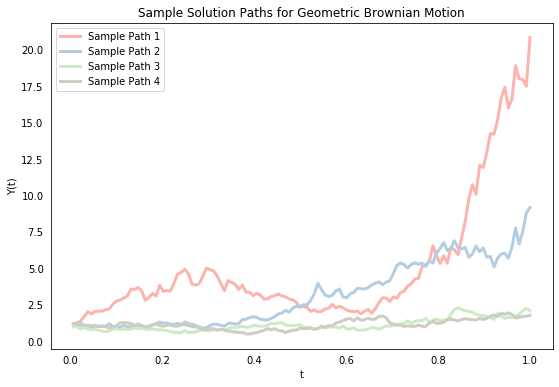

In [8]:
# Load packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Plot settings
plt.rcParams['figure.figsize'] = (9,6)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
pal = ["#FBB4AE","#B3CDE3", "#CCEBC5","#CFCCC4"]

# SDE model parameters
mu, sigma, X0 = 2, 1, 1

# Simulation parameters
T, N = 1, 2**7
dt = 1.0 / N
t = np.arange(dt, 1 + dt, dt)  # Start at dt because Y = X0 at t = 0

# Initiate plot object
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.ylabel('Y(t)'); plt.xlabel('t')

# Create and plot sample paths
for i in range(len(pal)):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Compute exact solution
    Y = X0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * B)
    
    # Add line to plot
    plt.plot(t, Y, label = "Sample Path " + str(i+1), color=pal[i])

# Add legend
plt.legend(loc = 2);

The above shows that the value $Y(t)$ for a given $t$ differs across sample paths (because it is a random variable). If we generate enough sample paths, then we can compute empirical statistics on them (like the mean) to approximate the actual parameters of the system (this is a version of Monte Carlo simulation). Below, we simulate 10,000 sample paths (we'll use inefficient `for` loops throughout this post. The goal here isn't computational speed but clarity). The gray lines in the left-hand plot show the first 200 of these. Like above, we can see that the value of $Y(t)$ differs a lot across sample paths, and we also begin to see more clearly that there is a distribution associated with each point $t$. The mean seems to be increasing (which is confirmed by the smooth green line, which represents the mean value of $Y(t)$ at each point), and the spread of the distribution also seems to be increasing.

Notice the red and blue vertical lines at $t=0.5$ and $t=0.75$. The right-hand plot creates the histograms of the associated $Y(t)$ values at these cross-sections (we can roughly visualize it as the left-hand cross-sections "flipped" clockwise 45 degrees). We see that the blue histogram, corresponding to the distribution of $Y(0.75)$ is skewed to the right of the red histogram corresponding to the distribution at $Y(0.5)$. The two vertical lines showing their respective means also confirm a higher mean value for $Y(0.75)$. We also see that $Y(0.75)$ has larger variance - as $t$ grows, there is more scope for the Brownian motion term to wander further off.

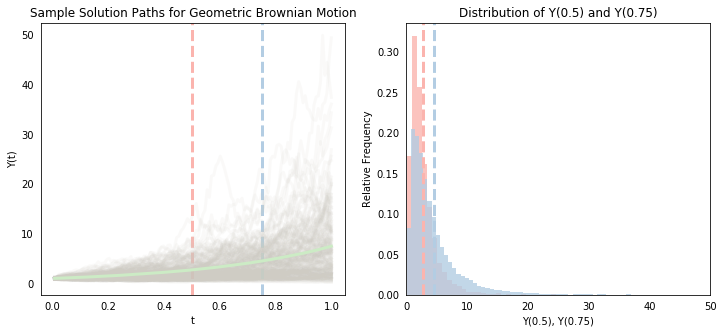

In [11]:
# --------------
# Left-hand plot
# --------------

# Initiate lineplot object
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
plt.ylabel('Y(t)'); plt.xlabel('t')
plt.title('Sample Solution Paths for Geometric Brownian Motion')
plt.axvline(x=.50, linestyle='--', color=pal[0])
plt.axvline(x=.75, linestyle='--', color=pal[1])

# Simulate sample paths
Y_1, Y_2, Y_total = [], [], []
for i in range(10000):
    
    # Create Brownian Motion
    np.random.seed(i)
    dB = np.sqrt(dt) * np.random.randn(N)
    B  = np.cumsum(dB)
    
    # Exact Solution
    Y = X0 * np.exp(((mu - 0.5 * sigma**2) * t) + (sigma * B))
    Y_1.append(Y[int(0.50 * N)])
    Y_2.append(Y[int(0.75 * N)])
    Y_total.append(Y)
    
    # Plot first 200 sample paths
    if i < 200:
        ax.plot(t, Y, label = "Sample Path " + str(i), color=pal[3], alpha=0.1)

# Plot average line
ax.plot(t, np.mean(Y_total, 0), label="Sample Path " + str(i), color=pal[2])

# --------------
# Right-hand plot
# --------------

fig.add_subplot(122)
plt.xlabel('Y(0.5), Y(0.75)'); plt.ylabel('Relative Frequency')
plt.xlim(0,50)
plt.title('Distribution of Y(0.5) and Y(0.75)')
plt.hist(Y_1,color=pal[0],bins=30,density=1,alpha=0.8)
plt.hist(Y_2,color=pal[1],bins=150,density=1,alpha=0.8)
plt.axvline(np.mean(Y_total, 0)[int(0.50 * N)],linestyle='--',color=pal[0])
plt.axvline(np.mean(Y_total, 0)[int(0.75 * N)],linestyle='--',color=pal[1]);

Unfortunately, most SDEs don't have tidy explicit solutions, so we can't just directly simulate solutions like above. An example is the Cox-Ingersoll-Ross model defined by $a(y)=\theta(\eta-y)$ and $b(y)=\sigma y$, which is popular in interest rate models. We therefore usually need to approximate $Y(t)$. This post describes two of the most popular numerical approximation methods - the Euler-Maruyama method and the Milstein method. We'll keep focusing on the Geometric Brownian Motion model above, despite the fact that we don't actually need to approximate it, because we'll find it useful to know the exact solution to assess the accuracy of our approximation methods. Throughout, we'll denote the approximation of $Y(t)$ as $X(t)$ and denote $X_n$ as the shorthand notation for $X(t_n)$ to declutter our equations. So $X_n$ is an approximation of $Y(t_n)$.

## Euler-Maruyama Method

We can rewrite the integral form of Geometric Brownian Motion as follows:

$$
Y(t_{n+1}) - Y(t_{n}) = \mu\int^{t_{n+1}}_{t_n}  Y(s) ds + \sigma\int^{t_{n+1}}_{t_n}  Y(s) dB(s)
$$

The simplest approximation to this is the Euler-Murayama method, which is the stochastic generalization of the standard Euler method for ODEs.

$$
X_{n+1} - X_{n} = \mu X_n\Delta t_n + \sigma X_n \Delta B_n
$$

It follows intuitively from the above if we think of the first integral being approximated by $\mu X_n\Delta t$ and the second by $\sigma X_n \Delta B_n$, although its formal derivation is based on a Taylor expansion (more on this below). We start below by simulating a single sample path for the exact solution $Y(t)$, and the corresponding sample path for E-M approximations using two different values of $\Delta t$ (note that we choose the "big $\Delta t$" values to be exact multiples `R` of the smaller $\Delta t$ values so we can evaluate the processes at the same points).

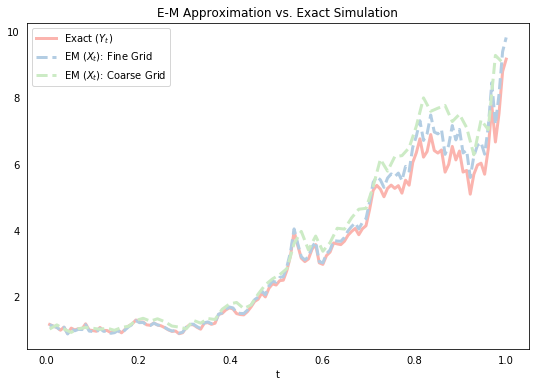

In [3]:
# Create Brownian Motion
np.random.seed(1)
dB = np.sqrt(dt) * np.random.randn(N)
B  = np.cumsum(dB)

# Exact Solution
Y = X0 * np.exp((mu - 0.5*sigma**2)*t + (sigma * B))

# EM Approximation - small dt
X_em_small, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j]
    X_em_small.append(X)

# EM Approximation - big dt
X_em_big, X, R = [], X0, 2
coarse_grid = np.arange(dt,1+dt,R*dt)
for j in range(int(N/R)):
    X += mu*X* (R*dt) + sigma*X*sum(dB[R*(j-1):R*j])
    X_em_big.append(X)    
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)", color=pal[0])
plt.plot(t, X_em_small, label="EM ($X_t$): Fine Grid", color=pal[1], ls='--')
plt.plot(coarse_grid, X_em_big, label="EM ($X_t$): Coarse Grid", color=pal[2], ls='--')
plt.title('E-M Approximation vs. Exact Simulation'); plt.xlabel('t'); plt.legend(loc = 2);

The above plot suggests that the E-M approximation does a pretty good job, and that the approximation gets "better" (ie. closer) as we reduce the size of our discrete time periods $\Delta t$. It turns out that this apparently intuitive notion of what it means for our approximate solution to "converge" on the actual solution is actually quite tricky to precisely define. There are in fact many defintions of what it means for one stochastic process to be close to another, but we'll formalize this below.

## Milstein method

The Milstein method increases the accuracy of the E-M approximation by adding a second-order "correction" term, which is derived from the stochastic Taylor series expansion of $Y(t)$ by applying Ito's lemma to the $a()$ and $b()$ functions  (detailed [here](https://www.math.nyu.edu/~cai/Courses/Derivatives/compfin_lecture_5.pdf)). It can be shown that $dB^2 = dt$ and therefore if we are interested in retaining the approximation terms up to the first order of $\Delta t$, then we need to keep terms up to the second order of the Brownian increment. The E-M approximation fails to do this by truncating the stochastic Taylor series expansion "one term short". The Milstein method yields the following differential form

$$
X_{n+1} - X_n = a(X_n)\Delta t + b(X_n)\Delta B_n \color{red}{+ 0.5b'(X_n)b(X_n)\left((\Delta B_n)^2-\Delta t\right)}
$$

which implies the following for our Geometric Brownian Motion example

$$
X_{n+1} - X_n = a(X_n)\Delta t + b(X_n)\Delta B_n \color{red}{+ 0.5\sigma^2 X_n\left((\Delta B_n)^2-\Delta t\right)}
$$

Below, we simulate a single path using the same draw from the Brownian motion above, and plot it with the exact solution and the E-M approximation. We can see that the Milstein approximation line in green looks to be closer than the corresponding E-M approximation. As mentioned above, there are many ways to formally define what we mean when we say that one stochastic process is close to another. We move on to this next.

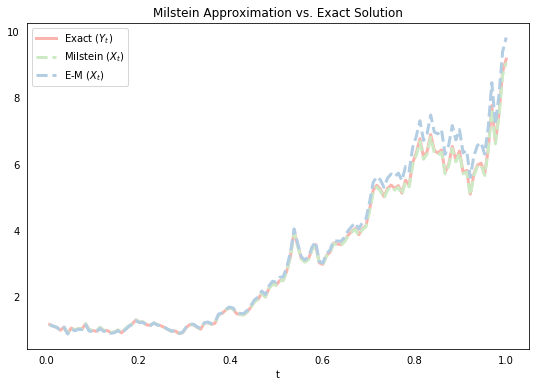

In [4]:
# Milstein Approximation
Xmil, X = [], X0
for j in range(N):  
    X += mu*X*dt + sigma*X*dB[j] + 0.5*sigma**2 * X * (dB[j] ** 2 - dt)
    Xmil.append(X)
    
# Plot
plt.plot(t, Y, label="Exact ($Y_t$)",color=pal[0])
plt.plot(t, Xmil, label="Milstein ($X_t$)",color=pal[2],ls='--')
plt.plot(t, X_em_small, label="E-M ($X_t$)",color=pal[1],ls='--')
plt.title('Milstein Approximation vs. Exact Solution')
plt.xlabel('t'); plt.legend(loc=2);

## Convergence

The concept of convergence formalizes what it means for one stochastic process to get closer to another as the discrete time steps $\Delta t$ are reduced. There are many different convergence definitions, but the two most common are "weak convergence" and "strong convergence". For *weak* convergence, we define the following error term

$$
e^w(\Delta t) = \sup_{t_n}|E(X(t_n)) - E(Y(t_n))|
$$

and for *strong* convergence we define

$$
e^s(\Delta t) = \sup_{t_n} E(|X(t_n) - Y(t_n)|)
$$

These terms are also often alternatively defined for a particular point rather than the the supremum over the interval $[0,T]$.
This is most commonly the end-point $T$ so the strong error term, for example, becomes simply $E(|X(T) - Y(T)|)$. In any case, we say that $X(t)$ exhibits strong or weak convergence to $Y(t)$ if the relevant error tends to zero with $\Delta t$

$$
\lim_{\Delta t\rightarrow 0}e^i(\Delta t) = 0
$$

Notice the difference between the two types of convergence. The weak error term simply computes the error between the expected values of the two stochastic processes at a given point. So weak convergence captures the average behavior of the simulated approximations. The strong error term, on the other hand, is the mean of errors, which captures the difference between the approximation and the exact solution for each individual sample path before the average is taken. Strong convergence is therefore more demanding.

So the appropriate sense of convergence here depends on whether we are interested in the "closeness" of the whole trajectory of the solution to the SDE (in which case we care about strong convergence) or in the expected value of some function of the process (which relates to weak convergence). For a European put option, for example, we are only interested in the the price of a stock at a given date, so we would mostly be interested in weak convergence. But if we are modeling, say, glucose levels of diabetic patients, then we are not just interested in how the approximations might behave on average, but we are also specifically interested in individual paths, because too large a divergence on any path can have drastic health consequences. In this case, of course, we'd be interested in stong convergence.

The code below computes each of the above error terms for the E-M and the Milstein approximations for a range of $\Delta t$ values. We do this by simulating 10,000 sample paths for each value of $\Delta t$. Notice that the strong errors are computed and stored within each Monte Carlo loop, whereas the weak errors are computed outside of the loop once the averages of the respective stochastic processes ($Y(t)$ and $X(t)$) are computed. This reflects the key difference between the two types of convergence discussed above. We then plot the weak and strong error terms for each approximation against the $\Delta t$ values on log-log axes (this will be explained later).

In [5]:
# Initiate dt grid and lists to store errors
str_err_em, str_err_mil, weak_err_em, weak_err_mil = [], [], [], []
dt_grid = [2 ** (R-10) for R in range(7)]
mc = 10000

# Loop over values of dt
for Dt in dt_grid:
    
    # Setup discretized grid 
    t = np.arange(Dt, 1 + Dt, Dt)
    n = len(t)
    
    # Initiate vectors to store errors and time series
    err_em, err_mil = np.zeros(n), np.zeros(n)
    Y_sum, Xem_sum, Xmil_sum = np.zeros(n), np.zeros(n), np.zeros(n)
    
    # Generate many sample paths
    for i in range(mc):
        
        # Create Brownian Motion
        np.random.seed(i)
        dB = np.sqrt(Dt) * np.random.randn(n)
        B  = np.cumsum(dB)
        
        # Exact solution
        Y = X0 * np.exp((mu - 0.5*sigma**2)*t + sigma * B)
        
        # Simulate stochastic processes
        Xemt, Xmilt, Xem, Xmil = X0, X0, [], []
        for j in range(n):

            # Euler-Maruyama
            Xemt += mu*Xemt* Dt + sigma * Xemt * dB[j]
            Xem.append(Xemt)
            
            # Milstein
            Xmilt += mu*Xmilt*Dt + sigma*Xmilt*dB[j] + 0.5*sigma**2*Xmilt*(dB[j]**2 - Dt)
            Xmil.append(Xmilt)
            
        # Compute strong errors and add to those across from other sample paths
        err_em  += abs(Y - Xem)
        err_mil += abs(Y - Xmil)
        
        # Add Y and X values to previous sample paths
        Y_sum += Y
        Xem_sum += Xem
        Xmil_sum += Xmil
        
    # Compute mean of absolute errors and find maximum (strong error)
    str_err_em.append(max(err_em / mc))
    str_err_mil.append(max(err_mil / mc))
    
    # Compute error of means and find maximum (weak error)
    weak_err_em.append(max(abs(Y_sum - Xem_sum)/mc))
    weak_err_mil.append(max(abs(Y_sum - Xmil_sum)/mc))

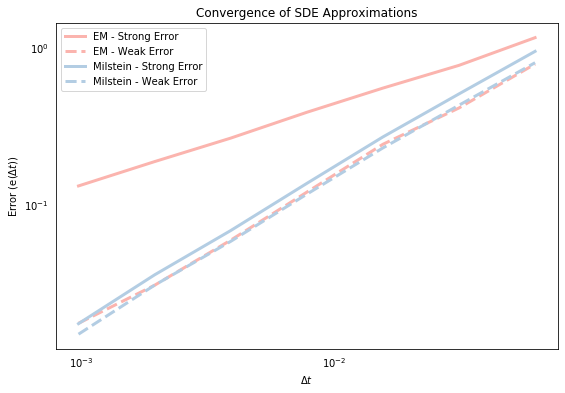

In [6]:
# Plot
plt.loglog(dt_grid, str_err_em, label="EM - Strong Error",color=pal[0])
plt.loglog(dt_grid, weak_err_em, label="EM - Weak Error",color=pal[0],ls='--')
plt.loglog(dt_grid, str_err_mil, label="Milstein - Strong Error",color=pal[1])
plt.loglog(dt_grid, weak_err_mil, label="Milstein - Weak Error",color=pal[1],ls='--')
plt.title('Convergence of SDE Approximations')
plt.xlabel('$\Delta t$'); plt.ylabel('Error (e($\Delta t$))'); plt.legend(loc=2);

The general relationship in the above graph is that the strong and weak error terms fall with $\Delta t$, which suggests that both approximations are stongly and weakly convergent. This is good news! Some other things to notice are that the weak errors (dashed lines) are always lower than the strong errors (which I think must be true by definition?). We also see that the strong Milstein errors are lower than the E-M errors. This was suggested by the last graph above, which showed that the Milstein approximation line was generally closer to the exact solution. So why are the weak errors roughly the same? Because although the errors in each individual sample path may be larger for the E-M approximation, on average the negative and the positive errors presumably cancel out so that the average paths of the E-M and Milstein approximations are roughly similar. We can also roughly see that the slope of the Milstein strong error seems to be higher than that of the E-M strong error, but the slopes of the weak errors are roughly similar. This brings us on to the concept of convergence rate.

## Rate of Convergence

In addition to knowing that errors shrink with respect to $\Delta t$, we are also generally interested in how fast an approximation converges as we reduce $\Delta t$. Why? Because reducing $\Delta t$ is costly in the sense that 1) computation time increases linearly with the reduction in $\Delta t$, and 2) there is a limit to the extent that we can reduce $\Delta t$ because of computational errors caused by the use of finite precision numbers increase. So we often want to know if the additional cost of reducing $\Delta t$ is worth it in terms of helping us to gain sufficient accuracy.

We say that an approximation has a rate of convergence equal to $\gamma$ if 

$$
e(\Delta t) \leq C (\Delta t) ^ \gamma
$$

The order of convergence measures the rate at which the error decays. If an approximation is convergent with order $\gamma$, and we make the step $k$ times smaller, then the approximation error will decrease by a factor of $k^\gamma$. So an order equal to 1 means that if we want to decrease the error by 100 times, we have to make the step 100 times smaller. For an order equal to 0.5, we would need to make the step 10,000 times smaller.

Above, we mentioned that strong convergence has implications for pathwise convergence (despite being a definition based on expected values). We can formalize this now using Markov's inequality, which says that the probability that a random variable $Z$ is greater than a constant $a>0$ is bounded above by $E(Z)/a$. That is,

$$
P(Z\geq a) \leq E(Z)/a
$$

Substituting in our strong error random variable $|X(t)-Y(t)|$ and recognizing the convergence rate yields the following:

$$
P(|X(t) - Y(t)|\geq a) \leq E(|X(t) - Y(t)|)/a \leq C(\Delta t)^\gamma/a
$$

Flipping the signs and substituting $a=(\Delta t)^{\gamma/2}$ implies that 

$$
P(|X(t) - Y(t)| < (\Delta t)^{\gamma/2}) \geq 1 - C(\Delta t)^{\gamma/2}
$$

which shows that the error at any fixed point is small with probability close to 1.

To compute the rate of convergence for our approximation methods, we can assume that the above inequality holds with rough equality, in which case taking the log of both sides allows us to write the following relationship

$$
\log(e(\Delta t)) =  \log(C) + \gamma \log(\Delta t)
$$

We can then estimate $\gamma$ by the slope of the lines on logarithmic axes (hence our log-log plot above) or simply by running OLS, which we do in the code below. The results below confirm (approximately) what we know to be true by theory (under certain assumptions about the $a()$ and $b()$ functions), which is that the Milstein method has both strong and weak convergence of order 1 whereas the E-M method has weak convergence of order 1, but strong convergence only of order 0.5 (which is reflected in the last graph).

In [7]:
# Import packages and setup design matrix
import statsmodels.api as sm
X = sm.add_constant(np.log(dt_grid))

# Run OLS on above simulations to estimate gamma values
results = sm.OLS(np.log(weak_err_em),X).fit()
print("Weak E-M Convergence:        "+ str(results.params[1]))

results = sm.OLS(np.log(weak_err_mil),X).fit()
print("Weak Milstein Convergence:   "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_em),X).fit()
print("\nStrong E-M Convergence:      "+ str(results.params[1]))

results = sm.OLS(np.log(str_err_mil),X).fit()
print("Strong Milstein Convergence: "+ str(results.params[1]))

Weak E-M Convergence:        0.9297415482552578
Weak Milstein Convergence:   0.9597912253628358

Strong E-M Convergence:      0.5203110424727103
Strong Milstein Convergence: 0.9631946258771567


## Conclusion

We applied the Euler-Maruyama and the Milstein numerical approximations to a Geometric Brownian Motion and showed, via example, the empirical convergence properties of each. Some useful references in writing these notes were [these slides](https://www.mimuw.edu.pl/~apalczew/CFP_lecture5.pdf), the first couple chapters of [this dissertation](https://trace.tennessee.edu/cgi/viewcontent.cgi?article=5331&context=utk_graddiss), [these notes](http://www-sop.inria.fr/members/Olivier.Faugeras/MVA/Articles_11/higham:01.pdf) and [these notes](http://math.gmu.edu/~tsauer/pre/sde.pdf). It's important to note that there are many other approximation schemes for SDEs. Another popular approach is the [Runge-Kutta method](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods), which achieves the same convergence properties as the Milstein method, but without the need to compute derivatives of the $b(\cdot)$ function. All the code for this blog post is available as a Python notebook at its [Github repository](https://github.com/hautahi/sde_simulation).